# Assignment 2: Long Short-Term Memory

*Author:* Thomas Adler

*Copyright statement:* This  material,  no  matter  whether  in  printed  or  electronic  form,  may  be  used  for  personal  and non-commercial educational use only.  Any reproduction of this manuscript, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

## Exercise 1: Analysis of the Jordan network

In the previous assignment we found that the Jordan network is incapable of memorizing information over longer time spans. Now we want to delve deeper into why this is case and how to solve this problem. To learn long-term dependencies, it is necessary that the gradient carries the error signal backwards in time. For instance, if the output at time $t$ depends on the input at time $s$ with $s < t$, then the Jacobian 
$$
J(t, s) = \frac{\partial a(t)}{\partial a(s)}
$$
is responsible for carrying the error signals from time $t$ backwards to time $s$. Calculate this Jacobian for the Jordan network and elaborate on the numerical stability of $J(t, s)$ for long time spans, i.e., when $t-s$ becomes large. Why is the Jordan network incapable of learning long-term dependencies?

########## YOUR SOLUTION HERE ##########
$$J(t,s) = \frac{\partial a(t)}{\partial a(s)}$$
$$J(t,s) = \frac{\partial a(t)}{\partial a(t-1)} \frac{\partial a(t-1)}{\partial a(t-2)} \frac{\partial a(t-2)}{\partial a(s)} = \prod_{l=1}^l J(t-s)$$
For r and a weights:

$$J(t-s) = r^l \prod_{l=1}^l f'(z(t-s))$$
rf'(z(t-s)) < 1 --> vanishing gradient
rf'(z(t-s)) > 1 --> exploding gradient


RNN are useful to model a present input affected by previous information, but in practice the relation cannot always be explained. Large weights cause larger gradients to a point where the learning rate cannot be adjusted and is unstable. Any large or small update signals will cause the learning rate to be non-adjustable. This is called as exploding and vanishing gradients. 
In case Wf'(a(t - s)) < 1 the gradient decays exponentially over time, the gradient vanishes, and if Wf'(a(t - s)) > 1 the gradient grows exponentially over time, the gradient explodes. Both cases do not allow the network to learn. With vanishing gradients the weight updates become so small and barely any learning occurs. With exploding gradients the absolute values of the weights quickly and the network overflows. The special case of rf'(a(s - t)) = 1 is numerically stable over long time spans.
By introducing gate functions into the cell structure, the long short-term memory (LSTM) could handle the problem of long-term dependencies well. 

The following figure depicts the LSTM architecture (without forget gate, which was introduced later). 

<img src="lstm_noFG.png" alt="LSTM" width="600"/>

We have
$$
a(t) = \varphi(W_a x(t) + R_a h(t-1) + b_a),
$$
where $a \in \{z, i, f, o\}$ and $\varphi$ is either sigmoid (for $i, f, o$) or tanh (for $z$). We alter the notation of the figure in that we write $h(t)$ instead of $y(t)$, which lets us use the latter for the output variable as we are used to. The LSTM forward rule is 
$$
c(t) = c(t-1) + z(t) \odot i(t) \\
h(t) = \tanh(c(t)) \odot o(t).
$$
To obtain predictions $\hat y(t)$ we facilitate an output layer
$$
\hat y(t) = \sigma(W_y h(t) + b_y).
$$

## Exercise 2: Forward pass of the gates

Consider the layer 
$$
a = \varphi(W x + R h + b).
$$
The modules $a \in \{z, i, o\}$ are called cell input, input gate, and output gate, respectively. The cell input uses $\varphi = \tanh$ whereas input gate and output gate use $\varphi = \sigma$. Implement the forward pass of the class `Gate` by implementing the methods `__init__` and `forward`. The method `__init__` should initialize the parameters uniformly in $[-0.01, 0.01]$. The method `forward` should implement the forward logic of the module. The activation function $\varphi$ should be exchangeable. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import expit as sigmoid

class Gate(object): 
    
    def __init__(self,input_size,hidden_size,output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        self.W_i = np.random.uniform(low=-0.01, high=0.01,size=(self.input_size + self.hidden_size, hidden_size))
        #self.R_i = np.random.uniform(low=-0.01, high=0.01, size=(hidden_size,hidden_size))
        self.b_i = np.random.uniform(low=-0.01, high=0.01,size=(self.hidden_size,1))
        
        self.W_z = np.random.uniform(low=-0.01, high=0.01,size=(self.input_size + self.hidden_size, hidden_size))
        #self.R_z = np.random.uniform(low=-0.01, high=0.01, size=(hidden_size,hidden_size))
        self.b_z = np.random.uniform(low=-0.01, high=0.01,size=(self.hidden_size,1))
        
        self.W_o = np.random.uniform(low=-0.01, high=0.01,size=(self.input_size + self.hidden_size, hidden_size))
        #self.R_o = np.random.uniform(low=-0.01, high=0.01, size=(hidden_size,hidden_size))
        self.b_o = np.random.uniform(low=-0.01, high=0.01,size=(self.hidden_size,1))
        
        self.W_y = np.random.uniform(low=-0.01, high=0.01,size=(self.output_size,self.hidden_size))
        self.b_y = np.random.uniform(low=-0.01, high=0.01,size=(self.output_size,1))
        
    def sigmoid(x):
        return 1/(1+np.exp(-x))

    def forward(self,x,h_1,cc):
        self.hh = h_1
        self.x = x
        self.Z = np.row_stack((x,h_1))
        self.a_i = self.W_i.T.dot(self.Z) + self.b_i
        self.i = sigmoid(self.a_i) #self.W_i.T.dot(x) + self.R_i.T.dot(hh) + self.b_i)
        self.a_o = self.W_o.T.dot(self.Z) + self.b_o
        self.o = sigmoid(self.a_o) #self.W_o.T.dot(x) + self.R_o.T.dot(hh) + self.b_o)
        self.a_z = self.W_z.T.dot(self.Z) + self.b_z
        self.z = np.tanh(self.a_z) #self.W_z.T.dot(x)+ self.R_z.T.dot(hh) + self.b_z)
        
        self.c = cc + self.z * self.i #np.multiply(self.z,self.i)
        self.h = np.tanh(self.c) * self.o #np.multiply(np.tanh(self.c),self.o)
        self.v = self.W_y.dot(self.h) + self.b_y
        self.y = sigmoid(self.v) #self.W_y).dot(self.h) + self.b_y

        return self.y

input_size = 1
hidden_size = 32
output_size = 1

x = np.random.uniform(-1,1,(input_size,1))
hh = np.random.uniform(-1,1,(hidden_size,1))
cc = np.random.uniform(-1,1,(hidden_size,1))

gate = Gate(input_size,hidden_size,output_size)
y = gate.forward(x,hh,cc)
print(y)

[[0.49752652]]


## Exercise 3: Gradients for the gates

To train a gate module, we need the gradients of the loss with respect to the parameters $W, R, b$. Further, if there are layers below that need training, then we also need the gradients with respect to $x$ and $h$. Given the gradient $\nabla_a L$, derive expressions for the gradients w.r.t $W, R, b, x, h$. 

########## YOUR SOLUTION HERE ##########

1. $\frac{\partial L}{\partial W_o} 
= \frac{\partial L}{\partial a_o} \frac{\partial a_o}{\partial W} 
= \frac{\partial L}{\partial a_o} \frac{\partial}{\partial W}(Wx + Rh + b)
= \frac{\partial L}{\partial a_o} x$


** $\frac{\partial L}{\partial W_i} 
= \frac{\partial L}{\partial a_i} x$


** $\frac{\partial L}{\partial W_z} 
= \frac{\partial L}{\partial a_z} x$


** $\frac{\partial L}{\partial W_y} 
= \frac{\partial L}{\partial a_y} x$


2. $\frac{\partial L}{\partial b_o} 
= \frac{\partial L}{\partial a_o} \frac{\partial a}{\partial b} 
= \frac{\partial L}{\partial a_o} \frac{\partial}{\partial b}(Wx + Rh + b)
= \frac{\partial L}{\partial a_o}$


** $\frac{\partial L}{\partial b_i} 
= \frac{\partial L}{\partial a_i}$

** $\frac{\partial L}{\partial b_z} 
= \frac{\partial L}{\partial a_z}$


** $\frac{\partial L}{\partial b_y} 
= \frac{\partial L}{\partial a_y}$



3. $\frac{\partial L}{\partial R_i} 
= \frac{\partial L}{\partial a_i} \frac{\partial a}{\partial R} 
= \frac{\partial L}{\partial a_i} \frac{\partial}{\partial R}(Wx + Rh + b)
= \frac{\partial L}{\partial a_i} h(t-1)$



** $\frac{\partial L}{\partial R_o} 
= \frac{\partial L}{\partial a_o} h(t-1)$


** $\frac{\partial L}{\partial R_z} 
= \frac{\partial L}{\partial a_z} h(t-1)$



4. $\frac{\partial L}{\partial x} 
= \frac{\partial L}{\partial a} \frac{\partial a}{\partial x} 
= \frac{\partial L}{\partial a} \frac{\partial}{\partial x}(Wx + Rh + b)
= \frac{\partial L}{\partial a} W
= \frac{\partial L}{\partial a_i}W_i + \frac{\partial L}{\partial a_z} W_z + \frac{\partial L}{\partial a_o} W_o$




5. $\frac{\partial L}{\partial h(t-1)} 
= \frac{\partial L}{\partial a} \frac{\partial a}{\partial h} 
= \frac{\partial L}{\partial a} \frac{\partial}{\partial h(t-1)}(Wx + Rh + b)
= \frac{\partial L}{\partial a} R
= \frac{\partial L}{\partial a_i}R_i + \frac{\partial L}{\partial a_z} R_z + \frac{\partial L}{\partial a_o} R_o$


 

## Exercise 4: Backward pass of the gates

Implement the backward pass of the class `Gate` by implementing the methods `zero_grad`, `backward`, and `update`. The method `zero_grad` should initialize/overwrite the gradients w.r.t. the parameters to zero. The method `backward` should take $\nabla_a L$ as argument and return $\nabla_x L$ and $\nabla_h L$. Moreover, it should add $\nabla_W L, \nabla_R L, \nabla_b L$ to the gradient buffers. The method update should perform a gradient-descent step to update the parameters using a learning rate $\eta$. 

In [2]:
########## YOUR SOLUTION HERE ##########

def zero_grad(self):
    self.W_i_grad = np.zeros((self.input_size + self.hidden_size, hidden_size))
    #self.R_i_grad = np.zeros((hidden_size, hidden_size))
    self.b_i_grad = np.zeros((hidden_size, 1))
    
    self.W_o_grad = np.zeros((self.input_size + self.hidden_size, hidden_size))
    self.b_o_grad = np.zeros((hidden_size, 1))
    #self.R_o_grad = np.zeros((hidden_size, hidden_size))
    
    #self.R_z_grad = np.zeros((hidden_size, hidden_size))
    self.W_z_grad = np.zeros((self.input_size + self.hidden_size, hidden_size))
    self.b_z_grad = np.zeros((hidden_size, 1))
    
    self.b_y_grad = np.zeros((output_size, 1))
    self.W_y_grad = np.zeros((output_size, hidden_size))
    
def backward(self, loss, h_1, L_c_nxt, x):
    L = loss
    #print(self.input_size)
    L_V = L * self.y * (1-self.y)
    #print("L",L.shape)
    #print("Wy",self.W_y.shape)
    #print("h1",h_1.shape)
    L_h = self.W_y.T.dot(L) + h_1
    L_o = L_h * np.tanh(self.c)
    L_ao = L_o * self.o * (1 - self.o)
    L_c = L_h * self.o * (1-np.tanh(self.c)**2)
    L_c += L_c_nxt
    L_z = L_c * self.i
    L_az = L_z * (1-(self.z**2))
    L_i = L_c * self.z
    L_ai = L_i * self.i * (1-self.i)
    #print(L_ai.shape)
    L_x = self.W_i.dot(L_ai) + self.W_o.dot(L_ao) + self.W_z.dot(L_az)
    L_Z = self.W_i.dot(L_ai) + self.W_o.dot(L_ao) + self.W_z.dot(L_az) 
    
    L_hh = L_Z[self.input_size:,:]
    
    #print("lhh",L_hh.shape)
    
    self.L_Wy = loss.dot(self.h.T)
    self.L_Wi = self.Z.dot(L_ai.T)
    self.L_Wo = self.Z.dot(L_ao.T)
    self.L_Wz = self.Z.dot(L_az.T)
    
    self.L_bi = L_ai
    self.L_bo = L_ao
    self.L_bz = L_az
    self.L_by = loss
    
    self.W_i_grad += self.L_Wi
    
    #print(self.R_i_grad.shape)
    #print(self.L_bi.shape)
    
    #self.R_i_grad += self.L_Ri
    self.b_i_grad += self.L_bi
        
    self.W_z_grad += self.L_Wz
    #self.R_z_grad += self.L_Rz
    self.b_z_grad += self.L_bz
        
    self.W_o_grad += self.L_Wo
    #self.R_o_grad += self.L_Ro
    self.b_o_grad += self.L_bo
        
    self.W_y_grad += self.L_Wy
    self.b_y_grad += self.L_by
           
    return L_x, L_c_nxt, L_hh

def update(self,learning_rate):
    self.W_o += learning_rate * self.W_o_grad
    self.W_i += learning_rate * self.W_i_grad
    self.W_z += learning_rate * self.W_z_grad
    self.W_y += learning_rate * self.W_y_grad
    
    #self.R_o += learning_rate * self.W_o_grad
    #self.R_i += learning_rate * self.W_i_grad
    #self.R_z += learning_rate * self.W_z_grad
    
    self.b_o += learning_rate * self.b_o_grad
    self.b_z += learning_rate * self.b_z_grad
    self.b_i += learning_rate * self.b_i_grad
    self.b_y += learning_rate * self.b_y_grad
        
setattr(Gate, 'zero_grad', zero_grad)
setattr(Gate, 'backward', backward)
setattr(Gate, 'update', update)

gate2 = Gate(input_size,hidden_size,output_size)

## Exercise 5: Forward pass of LSTM

Implement the forward pass of the class `LSTM` using the `Gate` module. Again, it should have the methods `__init__` and `forward` using the same initialization scheme as before. The method `forward` should evaluate and return $L(\hat y(T), y(T))$ where $L$ is the binary cross-entropy loss function and $T$ is the index of the last sequence element. Make sure to store all activations which are needed for the backward pass. 

In [4]:
class LSTM(object):
    def __init__(self,input_size,hidden_size,output_size):
        self.gate = Gate(input_size,hidden_size,output_size)
        self.hidden_size = hidden_size
        
    def bce(self,true,pred):
        #if (logits.all()==0):
         #   logits += 0.0000001
        #if (logits.all()==1):
         #   logits -= 0.0000001
        #if (logits.all()==float('nan')):
            #logits = 0.5
        
        loss = pred - true #np.multiply(targets, np.log(logits)) + np.multiply((1-targets),np.log(1-logits))
        
        return loss 
    
    def forward(self, xx, yy):
        hh = np.zeros((self.hidden_size,1))
        cc = np.zeros((self.hidden_size,1))
        self.Z_list = []
        self.xx = xx 
        #hh_l = []
        #cc_l = []
        #self.logits = []
        
        for x in self.xx:
            x = np.array([x]).T
            self.Z_list.append(np.row_stack((x,hh)))
            y = self.gate.forward(x,hh,cc)
            hh = self.gate.h
            cc = self.gate.c
            
            #hh_l.append(hh)
            #cc_l.append(cc)
            #self.logits.append(y)

            
            self.result = y
        return self.bce(np.array(self.result),yy)

In [5]:
T,D = 10,100
q = LSTM(100,32,1)
q.forward(np.random.uniform(-1,1,(T,D)), np.ones(T))

array([[0.49864904, 0.49864904, 0.49864904, 0.49864904, 0.49864904,
        0.49864904, 0.49864904, 0.49864904, 0.49864904, 0.49864904]])

## Exercise 6: Backward pass of LSTM with BPTT

Realize the backward pass of LSTM by implementing the methods `zero_grad`, `backward`, and `update`. Equations for the gradients can be found in the lecture script section 3.1 "Backpropagation for LSTM". 

In [6]:
########## YOUR SOLUTION HERE ##########
def zero_grad(self):
    self.gate.zero_grad()
    
def backward(self,loss,xx):
    self.Z_list = reversed(self.Z_list)
    loss = reversed(loss)
    h_prev = 0
    c_prev = 0
    
    for x, loss in zip(self.Z_list,loss):
        x_,c_prev,h_prev = self.gate.backward(loss,h_prev,c_prev,x)
        
def update(self,learning_rate):
    self.gate.update(learning_rate)
    
setattr(LSTM, 'zero_grad', zero_grad)
setattr(LSTM, 'backward', backward)
setattr(LSTM, 'update', update)

## Exercise 7: LSTM training

Train an LSTM with 32 hidden units on the task from assignment 1 with a sequence length of 100. Tune the number of update steps and the learning rate. After training, evaluate the model on 1000 sequences. 

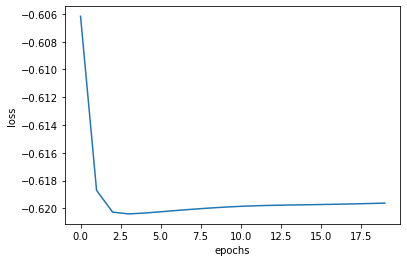

In [8]:
from random import random

def generate_data(T):
    first = 1
    end = 1
    
    if random()>0.5:
        first = -1
        end = 0
        
    np.random.seed(0xDEADBEEF)
    m,sigma = 0,0.2
    s = np.random.normal(m,sigma,T-1)
    
    d = s
    d = np.append(np.array([first]),d)
    d = np.append(d,np.array([end]))
    
    return np.array(d)

d = generate_data(32)

#training
all_losses = []
learning_rate = 0.01
input_len = 1
out_len = 1
hidden_len = 32
seq_len =1000
x = []
y = []

for i in range(100):
    d = generate_data(seq_len)
    x.append(d[:-1])
    y.append(d[-1])
    
x = np.array(x)
y = np.array(y)
epochs = 20
model = LSTM(input_len,hidden_len,out_len)
losses = []
loss = 0

for i in range(epochs):
    acc_loss = 0
    for xx,yy in zip(x,y):
        xx = np.array([xx]).T
        loss = model.forward(xx,yy)
        acc_loss += loss
        model.zero_grad()
        model.backward(np.array([loss]).T,xx)
        model.update(learning_rate)
    losses.append(loss)
    
all_losses = losses

#training loss
import matplotlib.pyplot as plt

x = list(range(len(all_losses)))
loss_l = np.squeeze(all_losses)

y = loss_l
x = range(len(y))
plt.plot(x,y,label = 'training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

#evaluation
all_losses = []
learning_rate = 0.01
input_len = 10
out_len = 20
hidden_len = 32
seq_len =1000
x = []
y = []

for i in range(100):
    d = generate_data(seq_len)
    x.append(d[:-1])
    y.append(d[-1])
    
x = np.array(x)
y = np.array(y)
model = LSTM(input_size,hidden_size,output_size)
losses = []
loss = 0

for xx,yy in zip(x,y):
    xx = np.array([xx]).T
    loss = model.forward(xx,yy)
    losses.append(loss)
    
all_losses = losses




## Exercise 8: The LSTM learning method and RTRL

Analyzing full BPTT for LSTM we find that the recurrent connections through the gates causes most of the intricacy of the backward logic, while the simple inner recurrent connections are responsible for carrying the error signals over long time spans. The *LSTM learning method* truncates the gradient of these outer recurrent connections. In other words, the gates treat $h(t)$ as if they were external inputs and disregard their dependence on the model. This simplifies the gradients and makes RTRL feasible. 

Since $h(t)$ are treated as external inputs, the key to RTRL is the recursion
$$
\frac{\partial c(t)}{\partial \theta} = \sum_{s=1}^t \frac{\partial c(t)}{\partial \theta(s)} = \frac{\partial c(t)}{\partial \theta(t)} + \frac{\partial c(t)}{\partial c(t-1)} \frac{\partial c(t-1)}{\partial \theta},
$$
where $\theta$ is the parameter vector that contains all the model parameters in one large vector. The parameters are shared in time and $\theta(t)$ denotes their usage at time $t$. Above recursion lets us collect the part of the gradient that depends on the past during forward pass. Due to the recurrent weights the size of $\theta$ is $O(I^2)$ and therefore $\frac{\partial c(t)}{\partial \theta}$ is $O(I^3)$. The matrix product on the right-hand side raises the computational complexity of RTRL to $O(I^4)$, which is the reason why RTRL is infeasible for most recurrent architectures. 

Let, e.g., $w_{jk}^i$ denote the element in the $j$-th row and $k$-th column of the matrix $W$ belonging to the input gate $i$. Show that $\frac{\partial c(t)}{\partial \theta}$ for the LSTM learning method has the form 
$$
\frac{\partial c_n(t)}{\partial w_{jk}^i} = \sum_{s=1}^t z_n(s) i_n(s)(1-i_n(s)) x_k(s) [n=j] \quad
\frac{\partial c_n(t)}{\partial r_{jk}^i} = \sum_{s=1}^t z_n(s) i_n(s)(1-i_n(s)) h_k(s-1) [n=j] \quad
\frac{\partial c_n(t)}{\partial b_j^i} = \sum_{s=1}^t z_n(s) i_n(s)(1-i_n(s)) [n=j] \\
\frac{\partial c_n(t)}{\partial w_{jk}^z} = \sum_{s=1}^t i_n(s) (1-z_n(s)^2) x_k(s) [n=j] \quad
\frac{\partial c_n(t)}{\partial r_{jk}^z} = \sum_{s=1}^t i_n(s) (1-z_n(s)^2) h_k(s-1) [n=j] \quad
\frac{\partial c_n(t)}{\partial b_j^z} = \sum_{s=1}^t i_n(s) (1-z_n(s)^2) [n=j],\\
$$
where $[n=j]$ is the Iverson bracket that evaluates to 1 if the expression inside is true and to 0 otherwise. What is the complexity of RTRL for the LSTM learning method?

########## YOUR SOLUTION HERE ##########


$
* \frac{\partial L}{\partial V(t)} = \hat y - y
\\
* \frac{\partial L}{\partial h} = \frac{\partial L}{\partial V(t)} \frac{\partial (Wh + b)}{\partial h} =  \frac{\partial L}{\partial V(t)} W
\\
* \frac{\partial L}{\partial o} = \frac{\partial L}{\partial V(t)} \frac{\partial V(t)}{\partial h} \frac{\partial h}{\partial o} = \frac{\partial L}{\partial h} \frac{\partial (o . tanh(c))}{\partial o} = \frac{\partial L}{\partial h} tanh(c)
\\
*\frac{\partial L}{\partial a_o} = \frac{\partial L}{\partial o} \frac{\partial o}{\partial a} = \frac{\partial L}{\partial o} o (1 - o)
\\
* \frac{\partial L}{\partial a_z} = \frac{\partial L}{\partial z} \frac{\partial z}{\partial a_z} = \frac{\partial L}{\partial z} (1 - z^2)
\\
* \frac{\partial L}{\partial z} = \frac{\partial L}{\partial c}  i
\\
* \frac{\partial L}{\partial i} = \frac{\partial L}{\partial c} z
\\
* \frac{\partial L}{\partial a_i} = \frac{\partial L}{\partial z} z i (1 - i)
\\
* \frac{\partial L}{\partial W} = \frac{\partial L}{\partial a} x
\\
*\frac{\partial L}{\partial R} = \frac{\partial L}{\partial a} h(t-1)
\\
*\frac{\partial L}{\partial b} = \frac{\partial L}{\partial a} 
$


So, using the above equations: 

$
\frac{\partial c}{\partial w^i_{jk}} = \sum^t_{s=1} z(s) i(s) (1 - i(s)) x_k(s)
\\
\frac{\partial c}{\partial w^z_{jk}} = \sum^t_{s=1} z(s) i(s) (1 - i(s)) x_k(s)
\\
\frac{\partial c}{\partial r^i_{jk}} = \sum^t_{s=1} z(s) i(s) (1 - i(s)) h_k(s-1)
\\
\frac{\partial c}{\partial r^z_{jk}} = \sum^t_{s=1} i(s) (1 - z^2(s)) h_k(s-1)
\\
\frac{\partial c}{\partial b^i_{jk}} = \sum^t_{s=1} z(s) i(s) (1 - i(s))
\\
\frac{\partial c}{\partial b^z_{jk}} = \sum^t_{s=1} z(s) i(s) (1 - i(s))
$

All under the condition $[n = j]$

Complexity of RTRL for the LSTM learning method:



## Exercise 9: Prepare LSTM for RTRL

Write a class `LSTM_RTRL` and implement the methods `__init__`, `zero_grad`, `update`. Do not use the `Gate` class this time but implement the gates directly so they can be trained via RTRL. Make sure to initialize all weights and gradient buffers accordingly. 

In [124]:
########## YOUR SOLUTION HERE ##########
class LSTM_RTRL(object):
    def __init__(self,input_size,hidden_size,output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        
        self.W_i = np.random.uniform(low=-0.01, high=0.01,size=(self.input_size + self.hidden_size, hidden_size))
        self.b_i = np.random.uniform(low=-0.01, high=0.01,size=(self.hidden_size,1))
        
        self.W_z = np.random.uniform(low=-0.01, high=0.01,size=(self.input_size + self.hidden_size, hidden_size))
        self.b_z = np.random.uniform(low=-0.01, high=0.01,size=(self.hidden_size,1))
        
        self.W_o = np.random.uniform(low=-0.01, high=0.01,size=(self.input_size + self.hidden_size, hidden_size))
        self.b_o = np.random.uniform(low=-0.01, high=0.01,size=(self.hidden_size,1))
        
        self.W_y = np.random.uniform(low=-0.01, high=0.01,size=(self.output_size,self.hidden_size))
        self.b_y = np.random.uniform(low=-0.01, high=0.01,size=(self.output_size,1))
    
    def zero_grad(self):
        self.W_i_grad = np.zeros((self.input_size + self.hidden_size, hidden_size))
        self.b_i_grad = np.zeros((hidden_size, 1))

        self.W_o_grad = np.zeros((self.input_size + self.hidden_size, hidden_size))
        self.b_o_grad = np.zeros((hidden_size, 1))

        self.W_z_grad = np.zeros((self.input_size + self.hidden_size, hidden_size))
        self.b_z_grad = np.zeros((hidden_size, 1))

        self.b_y_grad = np.zeros((output_size, 1))
        self.W_y_grad = np.zeros((output_size, hidden_size))
    
    def update(self,learning_rate):
        self.W_o += learning_rate * self.W_o_grad
        self.W_i += learning_rate * self.W_i_grad
        self.W_z += learning_rate * self.W_z_grad
        self.W_y += learning_rate * self.W_y_grad

        self.b_o += learning_rate * self.b_o_grad
        self.b_z += learning_rate * self.b_z_grad
        self.b_i += learning_rate * self.b_i_grad
        self.b_y += learning_rate * self.b_y_grad
    
#setattr(LSTM_RTRL, 'zero_grad', zero_grad)
#setattr(LSTM_RTRL, 'update', update)



## Exercise 10: Implement RTRL for the LSTM learning method

Add a method `forward` to the class `LSTM_RTRL` that processes one time step of an input sequence and updates the RTRL gradient buffers using the LSTM learning method. 

In [140]:
########## YOUR SOLUTION HERE ##########
def bce(self,true,pred):
        #if (logits.all()==0):
         #   logits += 0.0000001
        #if (logits.all()==1):
         #   logits -= 0.0000001
        #if (logits.all()==float('nan')):
            #logits = 0.5
    
    loss = (pred - true)**2 #np.multiply(targets, np.log(logits)) + np.multiply((1-targets),np.log(1-logits))
        
    return loss 
    
def forward1(self, xx, h_1, c_1, yy):
    zz = np.row_stack((xx,h_1))
    ai = self.W_i.T.dot(zz) + self.b_i
    i = sigmoid(ai)
    
    ao = self.W_o.T.dot(zz) + self.b_o
    o = sigmoid(ao)
    
    az = self.W_z.T.dot(zz) + self.b_z
    z = np.tanh(az)
    
    c = c_1 + z * i
    h = np.tanh(c) * o
    self.h = h
    self.c = c
    v = self.W_y.dot(h) + self.b_y
    y = sigmoid(v)
    
    L_V = 1
    L_Wi = zz.dot((z * i * (1-i)).T)
    L_Wo = zz.dot((o * (1-o)).T)
    L_Wz = zz.dot((i * (1 - z**2)).T)
    L_Wy = np.dot(L_V, h.T)
    
    L_bi = (z * i * (1 - i))
    L_bo = (o * (1 - o))
    L_bz = ((1 - z**2) * i)
    L_by = L_V
    
    self.W_i_grad += L_V * L_Wi
    self.W_o_grad += L_V * L_Wo
    self.W_z_grad += L_V * L_Wz
    self.W_y_grad += L_V * L_Wy
    
    self.b_i_grad += L_V * L_bi
    self.b_o_grad += L_V * L_bo
    self.b_z_grad += L_V * L_bz
    self.b_y_grad += L_V * L_by
    
    return y
    
    
def forward(self, x_l, yy)    :
    hh = np.zeros((self.hidden_size,1))
    cc = np.zeros((self.hidden_size,1))
    loss = 0
    
    for x in x_l:
        x = np.array([x]).T
     #   print(yy.shape)
        res = self.forward1(x,hh,cc,yy)
        hh = self.h
        cc = self.c
    #print("yyf",yy)        
    return self.bce(np.array(res),yy)

setattr(LSTM_RTRL, 'bce', bce)
setattr(LSTM_RTRL, 'forward1', forward1)
setattr(LSTM_RTRL, 'forward', forward)

## Exercise 11: LSTM training with RTRL

Again, train the LSTM on the task from assignment 1 using real-time recurrent learning in combination with the LSTM learning method. Start with a sequence length of 1. What is the maximum sequence length for which the LSTM can learn the task (at reasonable computational cost)? Compare the training behavior to that with BPTT. Explain possible differences.  

In [141]:
########## YOUR SOLUTION HERE ##########
from random import random

def generate_data(T):
    first = 1
    end = 1
    
    if random()>0.5:
        first = -1
        end = 0
        
    np.random.seed(0xDEADBEEF)
    m,sigma = 0,0.2
    s = np.random.normal(m,sigma,T-1)
    
    d = s
    d = np.append(np.array([first]),d)
    d = np.append(d,np.array([end]))
    
    return np.array(d)

d = generate_data(32)

In [145]:
#training
all_losses = []
seq_len = [1, 100]

for T in seq_len:
    learning_rate = 0.01
    input_len = 1
    out_len = 1
    hidden_len = 32
    seq_length = T
    x = []
    y = []

    for i in range(20):
        d = generate_data(seq_length)
        x.append(d[:-1])
        y.append(d[-1])
    
    x = np.array(x)
    y = np.array(y)
    epochs = 20
    model = LSTM_RTRL(input_len,hidden_len,out_len)
    losses = []
    lossx = []
    loss = 0
    #print("y",y.shape)
    #print("x",x.shape)
    for i in range(epochs):
        acc_loss = 0
        #print("y1",y.shape)
        for xx,yy in zip(x,y):
            #print("yy",yy)
            #print("xx",xx.shape)
            xx = np.array([xx]).T
            model.zero_grad()
            loss = model.forward(xx,yy)
            acc_loss += loss
            lossx.append((loss))
            model.update(learning_rate)
        losses.append(acc_loss)
    all_losses.append(lossx)


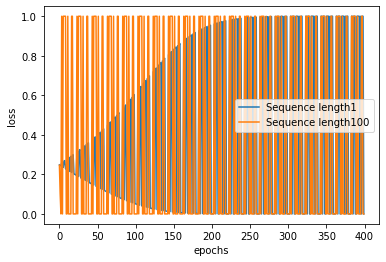

In [146]:
import matplotlib.pyplot as plt

x = list(range(len(all_losses[0])))
all_losses = np.squeeze(all_losses)

for i in range(len(all_losses)):
    y = all_losses[i]
    plt.plot(x,y,label = "Sequence length"+str(seq_len[i]))
    
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

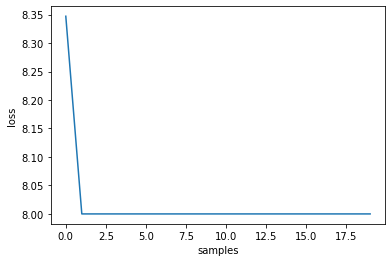

In [147]:
#evaluation
losses = np.squeeze(losses)

x = list(range(len(losses)))
y = losses

plt.plot(x,y,label = "Sequence lenght"+str(100))
plt.xlabel('samples')
plt.ylabel('loss')
plt.show()